# Fit Example - True 3D obliquity

In this tutorial we will see how to use ironman to fit for the true 3D obliquity. This is only recommended when you have information about the rotational period of the host star. 

Let's SUPPOSE we have measured a rotation period of 30 +/- 1 day for WASP-139. Then the only change to find the true obliquity will be in the priors file:

In [1]:
import ironman
import pandas as pd
import numpy as np
from astropy import units as u

Using the same data than in Example 1

In [2]:
tess = pd.read_csv("data/TESS_Y1_LC.csv")
bjd_tess1 = tess.time.values
flux_tess1 = tess.flux.values
flux_err_tess1 = tess.flux_err.values

tess = pd.read_csv("data/TESS_Y2_LC.csv")
bjd_tess2 = tess.time.values
flux_tess2 = tess.flux.values
flux_err_tess2 = tess.flux_err.values

harps = pd.read_csv("data/HARPS_RV.txt")
time_harps = harps["BJD"].values
rv_harps = harps['RV'].values
rv_err_harps = harps['RVe'].values

espresso = pd.read_csv("data/ESPRESSO_RV.csv")
time_espresso = espresso["Time"].values
rv_espresso = espresso["RV (km/s)"].values * 1000.0
rv_err_espresso = espresso["RV err (km/s)"].values * 1000.0

In [3]:
times_lc, fluxes, fluxes_error = {}, {}, {}
times_rvs, rvs, rvs_err =  {}, {}, {}
times_RM, RM, RM_err =  {}, {}, {}

times_lc["TESSY1"], fluxes["TESSY1"], fluxes_error["TESSY1"] = bjd_tess1, flux_tess1, flux_err_tess1
times_lc["TESSY2"], fluxes["TESSY2"], fluxes_error["TESSY2"] = bjd_tess2, flux_tess2, flux_err_tess2

times_rvs["HARPS"], rvs["HARPS"], rvs_err["HARPS"] = time_harps, rv_harps, rv_err_harps

times_RM["ESPRESSO"], RM["ESPRESSO"], RM_err["ESPRESSO"] = time_espresso, rv_espresso, rv_err_espresso

In [4]:
exp_times = {"TESSY1":False,"TESSY2":False,"ESPRESSO": 600.0/60.0/60.0/24.0}

In [5]:
data = ironman.DataOrganizer(output="Example 3 - Results",lc_time=times_lc,lc_data=fluxes,lc_err=fluxes_error,rv_time=times_rvs,rv_data=rvs,rv_err=rvs_err,rm_time=times_RM,rm_data=RM,rm_err=RM_err,verbose = True,exp_times=exp_times)

Reading data...
Data Ready!
Data saved ...
exp_times saved ...


Instead of fitting for the vsini, we will fit for the stellar inclination with an informative prior on the rotational period and radius of the star.

    - r_star: Radius of the host star (Rsun)
    - Prot_star: Rotational period of the host star (days)
    - cosi_star: Cosine of the stellar inclination

Additionally, with this parametrization we can sample the stellar mass instead of the stellar density:

    - m_star: Mass of the host star (Msun)

In [6]:
priors = ironman.Priors("priors/Example3_priors.dat",data)

Priors dictionary ready...
Detecting fixed parameters...
Fixed sigma_TESSY1 detected!
Fixed sigma_TESSY2 detected!
Fixed sigma_HARPS detected!
Fixed sigma_ESPRESSO detected!
Fixed gammadot detected!
Fixed gammadotdot detected!
Priors saved ...


In [7]:
fit = ironman.Fit(data=data,priors=priors)
postsamples = fit.run(n_live=500, nthreads = 24)

Fit class initialized.
Running dynesty with 500 nlive and 24 threads


28017it [05:16, 88.60it/s, batch: 4 | bound: 31 | nc: 1 | ncall: 1020004 | eff(%):  2.697 | loglstar: 14572.599 < 14581.399 < 14578.798 | logz: 14545.375 +/-  0.200 | stop:  0.806]        


Saved posteriors to Example 3 - Results/posteriors.txt


In [8]:
results = ironman.Results(fit)

Results class initialized.


In this case, we are sampling the r_star and m_star, so to know the radius, mass, and semimajor axis of the planet (in Earth units) we only have to do:

In [9]:
results.print_mass_radius_rho_sma_planet(r_units=u.Rearth,m_units=u.Mearth)

R_planet: 8.8805 +0.1589 -0.1702 earthRad
Sma_planet: 0.0605 +0.0007 -0.0007 AU
M_planet: 45.5711 +6.1197 -5.6772 earthMass
Rho_planet: 0.3574 +0.0545 -0.0473 g/cm^3


In [10]:
times_espresso = results.data.x["ESPRESSO"]
times_models_espresso = np.linspace(times_espresso[0],times_espresso[-1],5000)
rm_models = results.evaluate_RM_model(times_models_espresso,"ESPRESSO",n_models=True,n=5000)
rm_model_obs = results.evaluate_RM_model(times_espresso,"ESPRESSO")

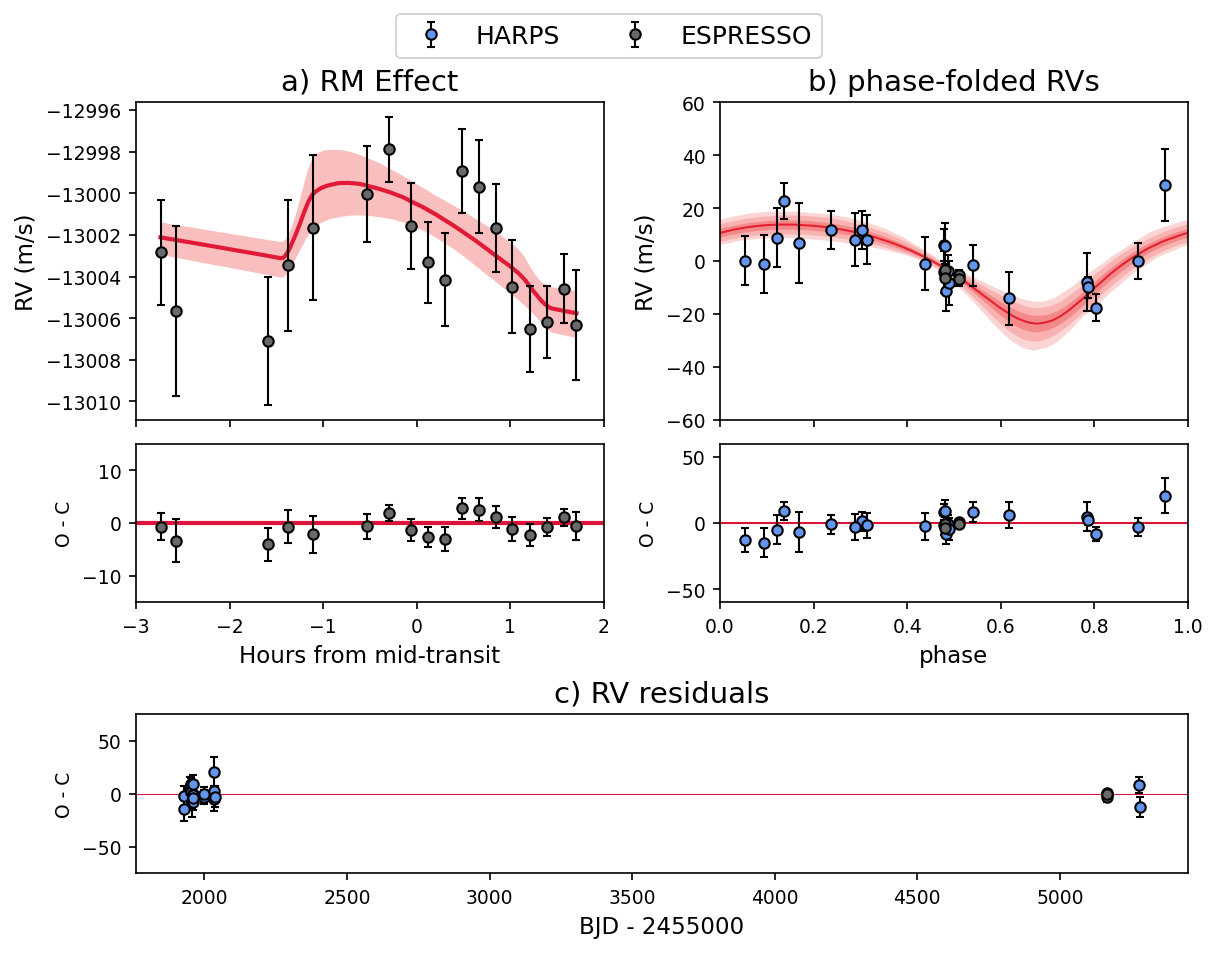

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8),dpi=150,constrained_layout=True)
gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:2, :3])
ax2 = fig.add_subplot(gs[2, :3], sharex = ax1)
ax3 = fig.add_subplot(gs[:2,3:])
ax4 = fig.add_subplot(gs[2,3:], sharex = ax3)
ax5 = fig.add_subplot(gs[3, :])

t0 = results.vals["t0_p1"]
P = results.vals["per_p1"]

############################################ RM Effect

jitter = results.vals["sigma_ESPRESSO"]
gamma = results.vals["gamma_ESPRESSO"]
times_model_plot = (times_models_espresso-t0-556*P)*24.
times, data, error = results.data.x["ESPRESSO"],results.data.y["ESPRESSO"],np.sqrt(results.data.yerr["ESPRESSO"]**2.0 + jitter**2.0)
times = (times-t0-556*P)*24. #556 corresponds to the number of the transit (i.e. the ESPRESSO transit midpoint was at t_i = 556 * per + t0 )
ax1.plot(times_model_plot,np.quantile(rm_models,0.5,axis=0)+gamma,lw=2,color="crimson",zorder=-10)
ax1.fill_between(times_model_plot,np.quantile(rm_models,0.16,axis=0)+gamma,np.quantile(rm_models,0.84,axis=0)+gamma,alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.errorbar(times,data,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=11)
ax1.set_title("a) RM Effect", fontsize=14)

res = data-rm_model_obs
ax2.errorbar(times,res,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax2.axhline(0.0,lw=2,color="crimson",zorder=-10)
ax2.set_ylim(-15,15)
ax2.set_xticks([-3,-2,-1,0,1,2])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=11)
ax2.set_ylabel('O - C')

######################################## RV time

times_harps = results.data.x["HARPS"]
times_espresso = results.data.x["ESPRESSO"]
first_n = times_espresso[:2]
last_k = times_espresso[-2:]
times_espresso = np.concatenate((first_n, last_k))
times_models = np.concatenate((times_harps,times_espresso))
times_models = np.linspace(times_models.min(),times_models.max(),5000)

rv_models = results.evaluate_RV_model(times_models,"HARPS",n_models=True,n=5000)
rv_model_harps = results.evaluate_RV_model(times_harps,"HARPS")
rv_model_espresso = results.evaluate_RV_model(times_espresso,"ESPRESSO")

jitter_harps = results.vals["sigma_HARPS"]
jitter_espresso = results.vals["sigma_ESPRESSO"]
data_harps, error_harps = results.data.y["HARPS"], np.sqrt(results.data.yerr["HARPS"]**2.0 + jitter_harps**2.0)
data_espresso, error_espresso = results.data.y["ESPRESSO"], np.sqrt(results.data.yerr["ESPRESSO"]**2.0 + jitter_espresso**2.0)
first_n = data_espresso[:2] #To include the ESPRESSO out-of-transit RVs in the plot
last_k = data_espresso[-2:]
data_espresso = np.concatenate((first_n, last_k))
first_n = error_espresso[:2]
last_k = error_espresso[-2:]
error_espresso = np.concatenate((first_n, last_k))

res_harps = data_harps-rv_model_harps
res_espresso = data_espresso-rv_model_espresso

ax5.errorbar(times_harps - 2455000,res_harps,error_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax5.errorbar(times_espresso - 2455000,res_espresso,error_espresso,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax5.axhline(0.0,lw=0.5,color="crimson",zorder=-10)
ax5.set_title("c) RV residuals", fontsize=14)
ax5.set_xlabel(r'BJD - 2455000',fontsize=11)
ax5.set_ylabel('O - C')
ax5.set_ylim(-75,75)

############################################# RV Phase

phase_harps = ((times_harps-t0 + 0.5*P) % P)/P
phase_espresso = ((times_espresso-t0 + 0.5*P) % P)/P
phase_models = ((times_models-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_models)

gamma_harps = results.vals["gamma_HARPS"]
gamma_espresso = results.vals["gamma_ESPRESSO"]

ax3.plot(phase_models[idx],np.quantile(rv_models,0.5,axis=0)[idx],lw=1.,color="crimson",zorder=-10)
ax3.fill_between(phase_models[idx],np.quantile(rv_models,0.16,axis=0)[idx],np.quantile(rv_models,0.84,axis=0)[idx],alpha=0.3,color="#EE2C2C",lw=0,zorder=-1) #1sigma models
ax3.fill_between(phase_models[idx],np.quantile(rv_models,0.02,axis=0)[idx],np.quantile(rv_models,0.98,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1) #2sigma models
ax3.fill_between(phase_models[idx],np.quantile(rv_models,0.0015,axis=0)[idx],np.quantile(rv_models,0.9985,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1) #3sigma models
ax3.errorbar(phase_harps,data_harps-gamma_harps,error_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue",label="HARPS")
ax3.errorbar(phase_espresso,data_espresso-gamma_espresso,error_espresso,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey",label="ESPRESSO")
ax3.set_title("b) phase-folded RVs", fontsize=14)
ax3.set_ylabel('RV (m/s)',fontsize=11)
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_ylim(-60,60)
ax3.set_xlim(0,1)

ax4.errorbar(phase_harps,res_harps,error_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax4.errorbar(phase_espresso,res_espresso,error_espresso,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax4.axhline(0.0,lw=1.,color="crimson",zorder=-10)
ax4.set_xlabel(r'phase',fontsize=11)
ax4.set_ylabel('O - C')
ax4.set_ylim(-60,60)

fig.set_facecolor('w')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, fontsize=12)
plt.show()
plt.close()

And for the photometric data

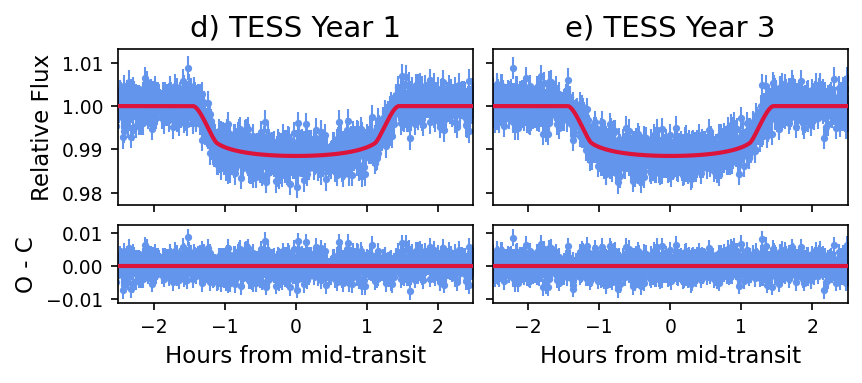

In [12]:
fig = plt.figure(figsize=(8,4),dpi=150,constrained_layout=True)
gs = fig.add_gridspec(6, 12)

ax7 = fig.add_subplot(gs[:2, 2:6])
ax8 = fig.add_subplot(gs[2, 2:6], sharex=ax7)
ax9 = fig.add_subplot(gs[:2, 6:10], sharey=ax7,sharex=ax7)
ax10 = fig.add_subplot(gs[2, 6:10],sharex=ax7,sharey=ax8)

times_TESSY1 = results.data.x["TESSY1"]
lc_model_TESSY1 = results.evaluate_LC_model(times_TESSY1,"TESSY1")
jitter_TESSY1 = results.vals["sigma_TESSY1"]
phase_TESSY1 = ((times_TESSY1-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_TESSY1)
data_TESSY1, error_TESSY1 = results.data.y["TESSY1"], np.sqrt(results.data.yerr["TESSY1"]**2.0 + jitter_TESSY1**2.0)
ax7.plot((phase_TESSY1[idx]-0.5)*P*24.,lc_model_TESSY1[idx],lw=2,color="crimson",zorder=10)
ax7.errorbar((phase_TESSY1-0.5)*P*24.,data_TESSY1,error_TESSY1,fmt=".",color="cornflowerblue",elinewidth=1)
ax7.set_yticks([0.98,0.99,1,1.01])
ax7.set_xlim(-2.5,2.5)
ax7.set_xticks([-2,-1,0,1,2])
plt.setp(ax7.get_xticklabels(), visible=False)
ax7.set_ylabel('Relative Flux',size=11)
ax7.set_title("d) TESS Year 1",fontsize=14)
res_TESSY1 = data_TESSY1-lc_model_TESSY1
ax8.errorbar((phase_TESSY1-0.5)*P*24.,res_TESSY1,error_TESSY1,fmt=".",color="cornflowerblue",elinewidth=1)
ax8.axhline(0.0,lw=2,color="crimson",zorder=10)
#ax8.set_xlim(-3,3)
ax8.set_xlabel(r'Hours from mid-transit',size=11)
ax8.set_ylabel('O - C',size=11)

times_TESSY2 = results.data.x["TESSY2"]
lc_model_TESSY2 = results.evaluate_LC_model(times_TESSY2,"TESSY2")
jitter_TESSY2 = results.vals["sigma_TESSY2"]
phase_TESSY2 = ((times_TESSY2-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_TESSY2)
data_TESSY2, error_TESSY2 = results.data.y["TESSY2"], np.sqrt(results.data.yerr["TESSY2"]**2.0 + jitter_TESSY2**2.0)
ax9.plot((phase_TESSY2[idx]-0.5)*P*24.,lc_model_TESSY2[idx],lw=2,color="crimson",zorder=10)
ax9.errorbar((phase_TESSY2-0.5)*P*24.,data_TESSY2,error_TESSY2,fmt=".",color="cornflowerblue",elinewidth=1)
plt.setp(ax9.get_xticklabels(), visible=False)
plt.setp(ax9.get_yticklabels(), visible=False)
ax9.minorticks_off()
#rmfit.utils.ax_apply_settings(ax9,ticksize=20)
ax9.set_title("e) TESS Year 3",fontsize=14)
res_TESSY2 = data_TESSY2-lc_model_TESSY2
ax10.errorbar((phase_TESSY2-0.5)*P*24.,res_TESSY2,error_TESSY2,fmt=".",color="cornflowerblue",elinewidth=1)
ax10.axhline(0.0,lw=2,color="crimson",zorder=10)
ax10.set_xlabel(r'Hours from mid-transit',size=11)
plt.setp(ax10.get_yticklabels(), visible=False)
ax10.minorticks_off()

fig.set_facecolor('w')
plt.show()
plt.close()

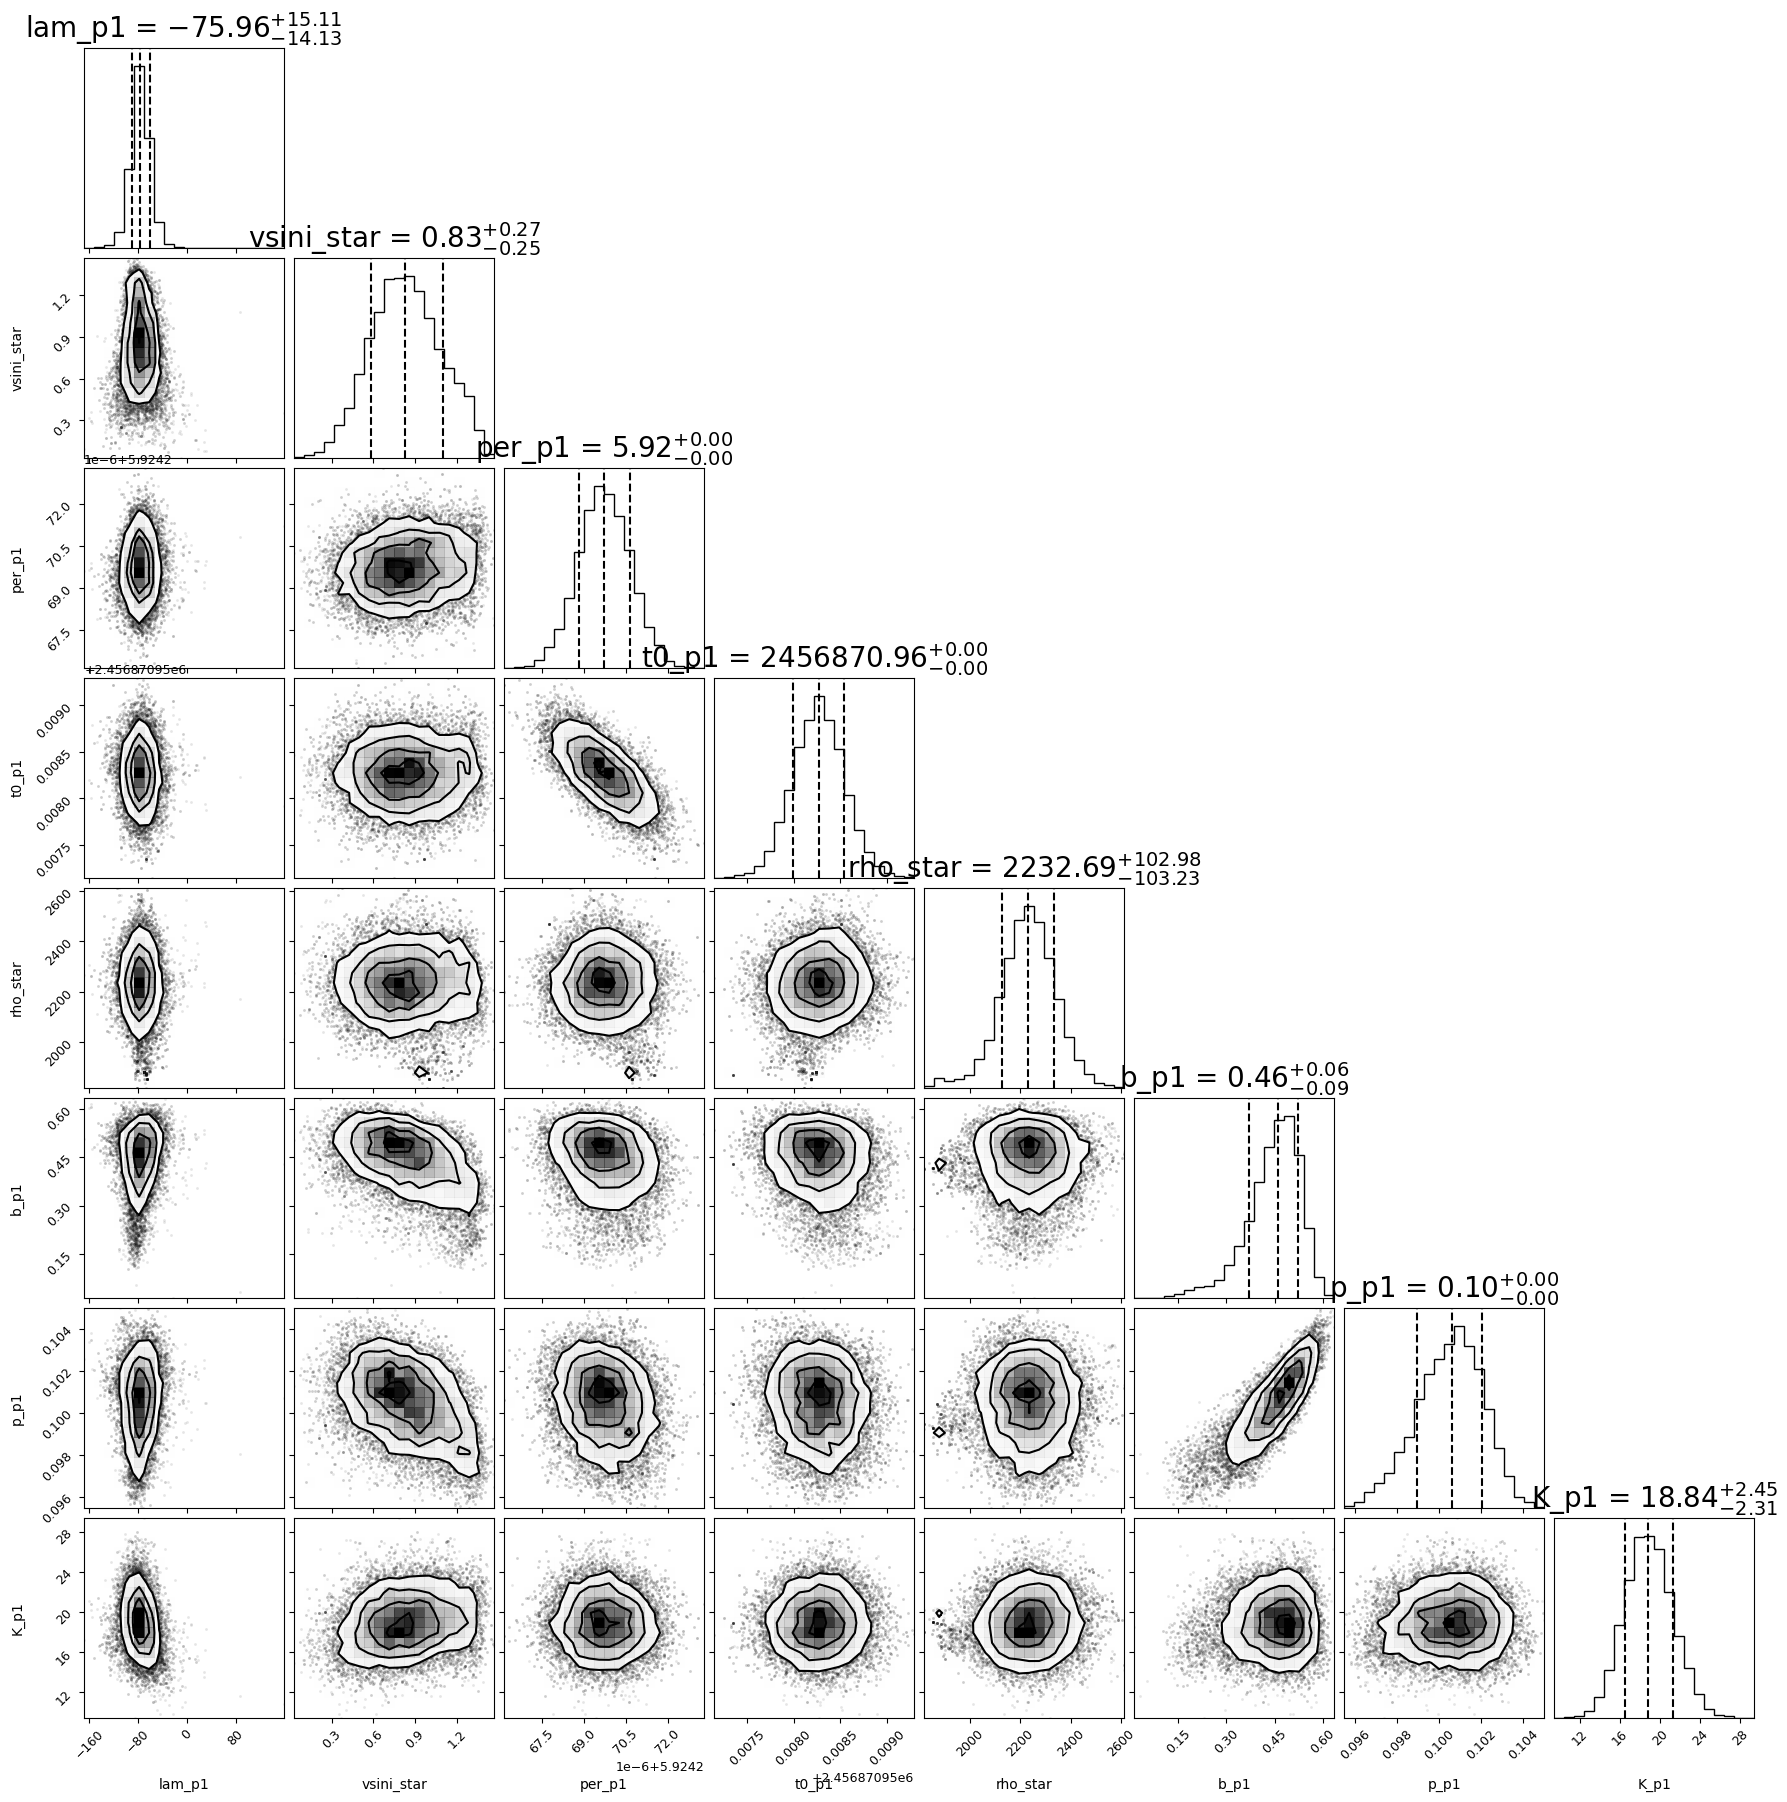

In [13]:
import corner

to_corner = results.chain[["lam_p1", "vsini_star", "per_p1", "t0_p1", "rho_star", "b_p1", "p_p1","K_p1"]]
corner.corner(to_corner.values,labels=to_corner.columns,quantiles=[0.16, 0.5, 0.84],label_kwargs={"fontsize": 10},
    show_titles=True,
    title_kwargs={"fontsize": 20})
plt.show()

And to plot the true obliquity parameters

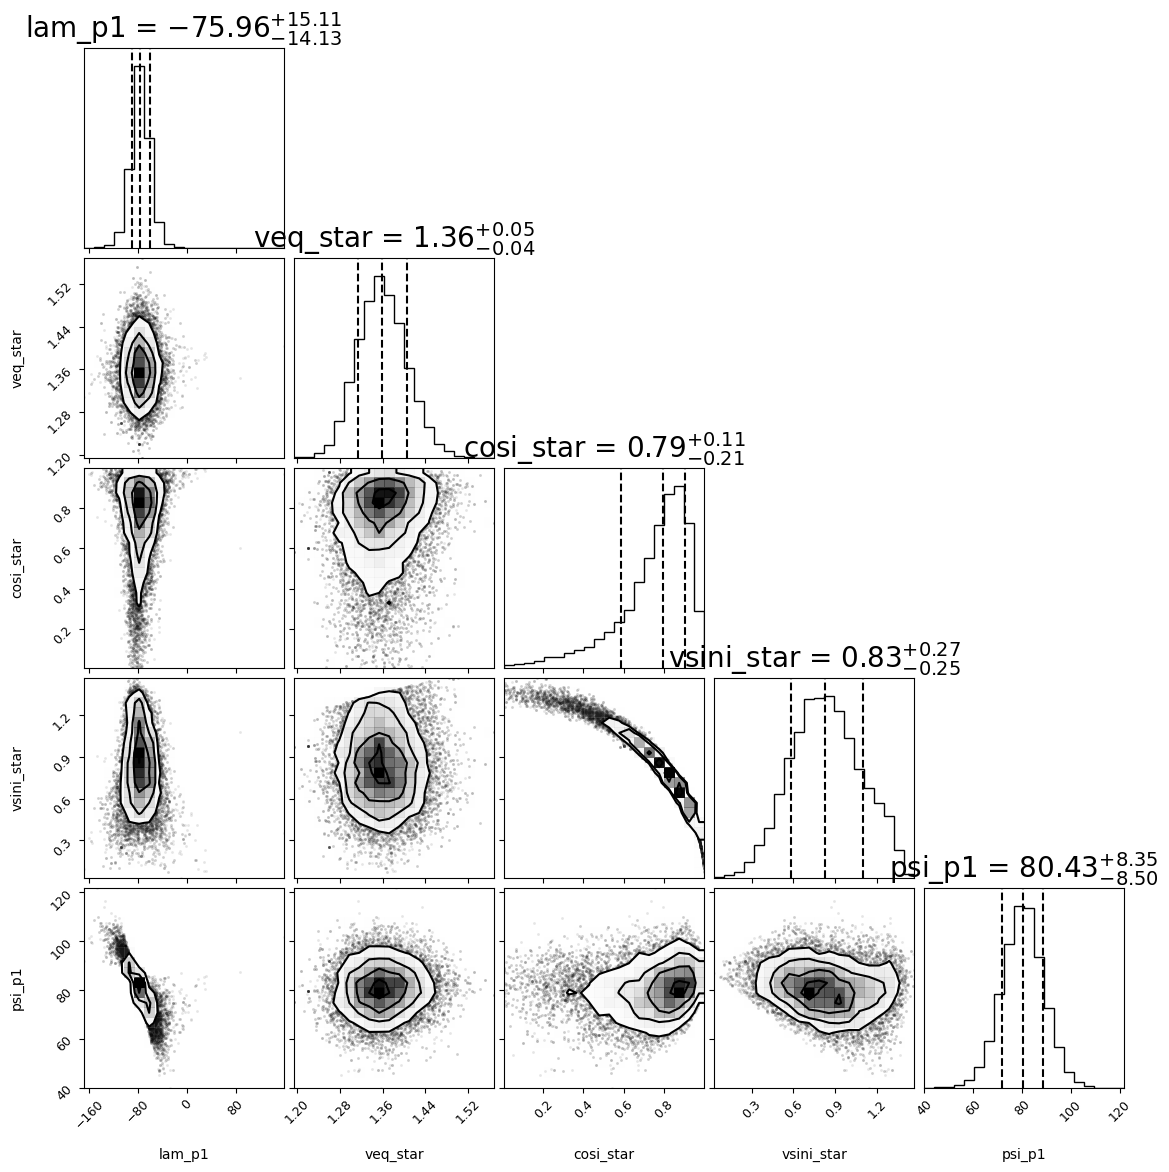

In [14]:
to_corner = results.chain[["lam_p1", "veq_star", "cosi_star", "vsini_star", "psi_p1"]]
corner.corner(to_corner.values,labels=to_corner.columns,quantiles=[0.16, 0.5, 0.84],label_kwargs={"fontsize": 10},
    show_titles=True,
    title_kwargs={"fontsize": 20})
plt.show()

In this example we have found a FICTICIONAL true obliquity of 80 +/- 8 deg